In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.3 MB/s eta 0:00:00


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

[1, 2, 3, 4, 5, 6, 7, 8, 9] === ['Built-up', 'Bareland', 'Water', 'Wetland', 'Herbaceous', 'Dry shrub', 'Wet shrub', 'Mixed Crop Types', 'Plantation forest'];

In [ ]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Parameter
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 9
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#FF8C00', '#006400']
SAMPLE_PATH = '/content/drive/MyDrive/GEE_images/points.csv'
IMAGE_PATH = '/content/drive/MyDrive/GEE_images/Barren_Land_Analysis.tif'

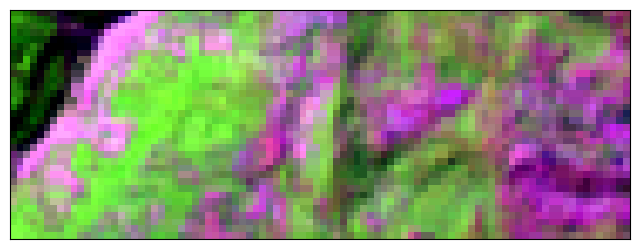

<Axes: >

In [ ]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
14433,0.013290,0.019863,0.048930,0.027755,0.332730,0.144685,0.058197,0.564647,0.702259,0.393882,-0.743594,-0.393882,0.426294,70,8,train
14955,0.015627,0.019450,0.049947,0.027040,0.363723,0.172212,0.067410,0.609893,0.687289,0.357338,-0.758515,-0.357338,0.437365,22,8,train
5422,0.029102,0.035208,0.071315,0.055117,0.270002,0.148920,0.073570,0.401909,0.571735,0.289033,-0.582119,-0.289033,0.338667,8,4,train
18354,0.022172,0.027164,0.058005,0.045754,0.265341,0.125903,0.060645,0.410863,0.627929,0.356399,-0.641221,-0.356399,0.349817,28,9,train
14067,0.037545,0.042701,0.085037,0.079056,0.408438,0.264530,0.124830,0.527005,0.531830,0.213840,-0.655352,-0.213840,0.358794,73,8,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12829,0.022282,0.029735,0.062061,0.041161,0.346728,0.159659,0.063271,0.557325,0.691359,0.369419,-0.696365,-0.369419,0.432367,4,7,test
153,0.086688,0.096794,0.129876,0.139845,0.214700,0.245541,0.199822,0.140936,0.035891,-0.067011,-0.246168,0.067011,0.102655,11,1,train
11365,0.015737,0.019065,0.051982,0.028030,0.324618,0.126452,0.049287,0.549313,0.736364,0.439322,-0.723938,-0.439322,0.439086,7,7,train
5067,0.034795,0.048875,0.088956,0.088145,0.189194,0.093810,0.049549,0.186919,0.584919,0.337041,-0.360372,-0.337041,0.308745,8,4,train


In [ ]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (14853, 14, 1)
Test features: (4043, 14, 1)
Train label: (14853, 10)
Test label: (4043, 10)


In [ ]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.2
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 13, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 4, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,274 (325.29 KB)

 Trainable params: 83,274 (325.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.1664 - loss: 2.2094 - val_accuracy: 0.1452 - val_loss: 2.2015
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.1949 - loss: 2.0436 - val_accuracy: 0.1590 - val_loss: 2.0417
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.2301 - loss: 1.8852 - val_accuracy: 0.3040 - val_loss: 1.8162
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.2877 - loss: 1.7139 - val_accuracy: 0.4143 - val_loss: 1.5828
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.3975 - loss: 1.5362 - val_accuracy: 0.5523 - val_loss: 1.2994
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.4924 - loss: 1.3140 - val_accuracy: 0.6495 - val_loss: 1.1166
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5806 - loss: 1.1194 - val_accuracy: 0.6839 - val_loss: 0.9825
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6451 - loss: 0.9659 - val_accuracy:

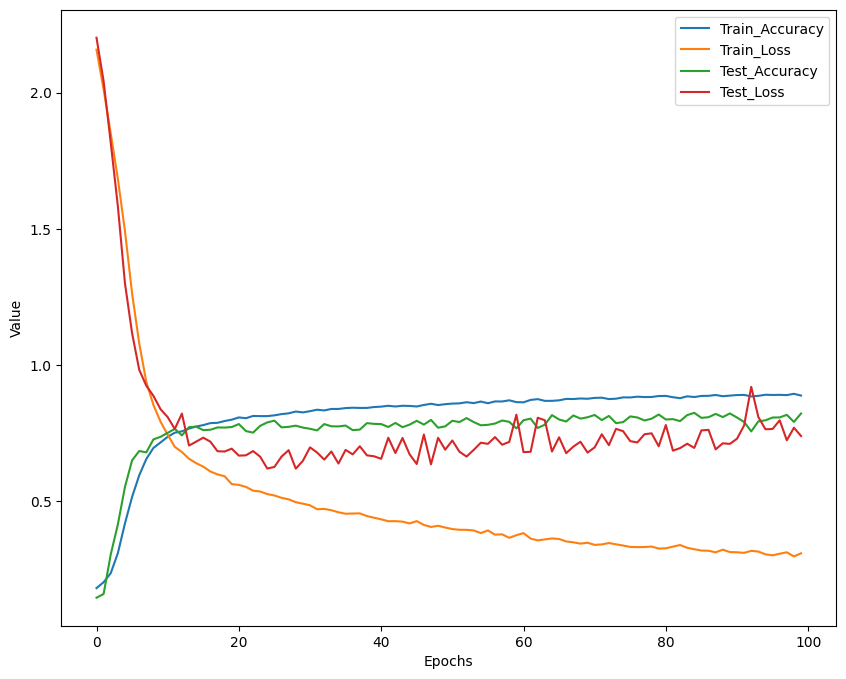

In [ ]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           1       0.94      0.93      0.94       247
           2       0.75      0.67      0.71       392
           3       0.99      0.78      0.87       353
           4       0.47      0.89      0.61       293
           5       0.94      0.73      0.82       398
           6       0.86      0.80      0.83       678
           7       0.85      0.87      0.86       792
           8       0.85      0.80      0.83       605
           9       0.96      1.00      0.98       285

    accuracy                           0.82      4043
   macro avg       0.85      0.83      0.83      4043
weighted avg       0.85      0.82      0.83      4043



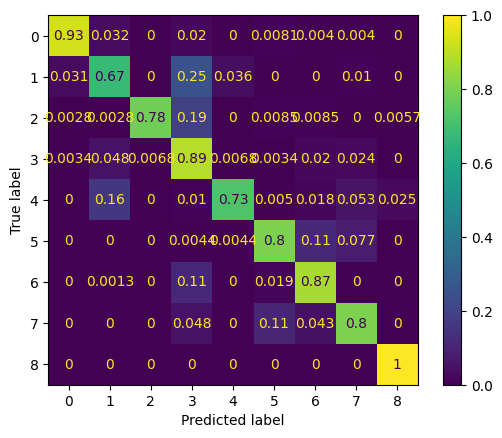

In [ ]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

# [1, 2, 3, 4, 5, 6, 7, 8, 9] === ['Built-up', 'Bareland', 'Water', 'Wetland', 'Herbaceous', 'Dry shrub', 'Wet shrub', 'Mixed Crop Types', 'Plantation forest'];

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


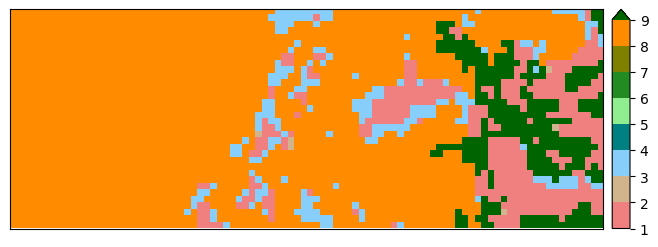

<Axes: >

In [ ]:
# Predict image using the model
image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(14, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)




In [ ]:
# Save file to drive
save_location = '/content/drive/MyDrive/GEE_images/'
name = 'test_passed.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()

In [ ]:
model.save('my_model.h5')

# Download the saved model to local PC
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 13, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 4, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249,824 (975.88 KB)

 Trainable params: 83,274 (325.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,550 (650.59 KB)

In [ ]:
# import tensorflow as tf

# model = tf.keras.models.load_model("my_model.h5")  # Load your model

# # Print model input shape
# for layer in model.layers:
#     print(layer.name, "expects", layer.input_shape)


In [ ]:
import rasterio

# Path to saved test file
test_image_path = "/content/drive/MyDrive/GEE_images/Landsat_Test_Image.tif"

# Open the test image
with rasterio.open(test_image_path) as src:
    print(f"Image Shape: {src.height} x {src.width}")
    print(f"Number of Bands: {src.count}")
    print(f"Coordinate Reference System (CRS): {src.crs}")
    print(f"Transform: {src.transform}")

    # Read all bands and stack
    image_array = []
    for i in range(src.count):  # Loop through bands
        band = src.read(i + 1)
        print(f"Band {i+1} Shape: {band.shape}")
        image_array.append(band)

    image_array = np.stack(image_array, axis=-1)  # Stack bands

print(f"Final Stacked Image Shape: {image_array.shape}")


Image Shape: 193 x 790
Number of Bands: 14
Coordinate Reference System (CRS): EPSG:4326
Transform: | 0.00, 0.00, 72.90|
| 0.00,-0.00, 19.23|
| 0.00, 0.00, 1.00|
Band 1 Shape: (193, 790)
Band 2 Shape: (193, 790)
Band 3 Shape: (193, 790)
Band 4 Shape: (193, 790)
Band 5 Shape: (193, 790)
Band 6 Shape: (193, 790)
Band 7 Shape: (193, 790)
Band 8 Shape: (193, 790)
Band 9 Shape: (193, 790)
Band 10 Shape: (193, 790)
Band 11 Shape: (193, 790)
Band 12 Shape: (193, 790)
Band 13 Shape: (193, 790)
Band 14 Shape: (193, 790)
Final Stacked Image Shape: (193, 790, 14)


In [ ]:
print(model.input_shape)


(None, 14, 1)


In [ ]:
import numpy as np

# Load the test image correctly
with rasterio.open("/content/drive/MyDrive/GEE_images/Landsat_Test_Image.tif") as src:
    image_array = []
    for i in range(14):  # Read all 14 bands
        image_array.append(src.read(i + 1))

# Convert (14, 193, 790) → (14,)
image_mean = np.mean(image_array, axis=(1, 2))  # Average over height & width

# Reshape for Conv1D: (batch_size, 14, 1)
image_input = image_mean.reshape(1, 14, 1)  # ✅ Correct shape

print("Fixed Input Shape for Model:", image_input.shape)  # Should be (1, 14, 1)

# Pass to model
prediction = model.predict(image_input)
print("Prediction Output Shape:", prediction.shape)


Fixed Input Shape for Model: (1, 14, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction Output Shape: (1, 10)


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
pip install streamlit rasterio matplotlib numpy Pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from PIL import Image

# Load Model (Dummy Function)
def load_model():
    return None  # Replace with actual model

# Function to process TIFF image
def process_tiff(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()  # Read all bands

    # Example processing: Normalizing band 1
    band_1 = image[0, :, :]
    processed_band = (band_1 - band_1.min()) / (band_1.max() - band_1.min())  # Normalize

    return processed_band

# Streamlit UI
st.title("Multi-band TIFF Image Processing")

uploaded_file = st.file_uploader("Upload a TIFF Image", type=["tif", "tiff"])

if uploaded_file:
    with rasterio.open(uploaded_file) as src:
        image = src.read()

    st.write(f"Number of Bands: {image.shape[0]}")  # (Bands, Height, Width)

    # Display any three bands as RGB
    fig, ax = plt.subplots(figsize=(6, 6))
    show(image[[2, 1, 0]], ax=ax)  # Assuming bands 3,2,1 are RGB
    st.pyplot(fig)

    # Process Image (Example: Normalize Band 1)
    processed_band = process_tiff(uploaded_file)

    fig2, ax2 = plt.subplots()
    ax2.imshow(processed_band, cmap="gray")
    ax2.set_title("Processed Band 1")
    st.pyplot(fig2)


2025-03-01 04:42:31.909 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 04:42:32.350 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-01 04:42:32.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 04:42:32.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 04:42:32.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 04:42:32.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 04:42:32.355 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 04:42:32.355 Thread 'MainThread': mi